In [198]:
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
import torchtext
from string import punctuation
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

train_data = pd.read_csv('./Data/agNews/train.csv')

In [199]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [200]:
train_data['Class Index'].unique()

array([3, 4, 2, 1])

In [201]:
classes = ['World', 'Sports', 'Business', 'Sci/Tech']

In [202]:
train_data['Description'][9]

" NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again."

In [203]:
train_data['Class Index'][8000]

4

In [204]:
labels = np.array(train_data['Class Index']).tolist()
description = np.array(train_data['Description']).tolist()
title = np.array(train_data['Title']).tolist()

In [205]:
data = [singleTitle + " " + description[i]  for i, singleTitle in enumerate(title)]   

(array([30000.,     0.,     0., 30000.,     0.,     0., 30000.,     0.,
            0., 30000.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

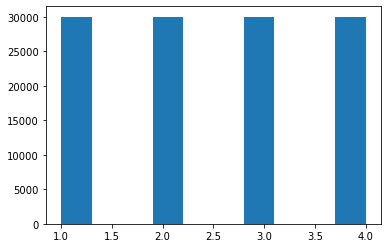

In [206]:


plt.hist(labels)

In [207]:
np.mean(labels)

2.5

In [208]:
print(data[2000] + " --> " + classes[labels[2000] - 1])

Applied Materials Reports Profit in 3Q Applied Materials Inc., the world #39;s largest supplier of machines that make computer chips, Tuesday said surging sales in its latest quarter surpassed its own and Wall Street estimates.  --> Business


PreProcessing From here --> torchtext

In [209]:
# tokenizer, changing the values to tokens
tokenizer = get_tokenizer('basic_english')
tokenizer(data[0])

['wall',
 'st',
 '.',
 'bears',
 'claw',
 'back',
 'into',
 'the',
 'black',
 '(',
 'reuters',
 ')',
 'reuters',
 '-',
 'short-sellers',
 ',',
 'wall',
 'street',
 "'",
 's',
 'dwindling\\band',
 'of',
 'ultra-cynics',
 ',',
 'are',
 'seeing',
 'green',
 'again',
 '.']

In [210]:
clean_data = lambda x: ''.join([i for i in x if i not in punctuation])
test = clean_data("Hello #cool")
test

'Hello cool'

In [211]:
def yield_tokens(batch):
    for i in batch:
        yield tokenizer(i)

vocab = build_vocab_from_iterator(yield_tokens(data), specials=['<unk>'])
vocab.set_default_index(vocab["<unk>"])

In [212]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [213]:
new_clean_data = [clean_data(i) for i in data]

In [214]:
new_clean_data[0]

'Wall St Bears Claw Back Into the Black Reuters Reuters  Shortsellers Wall Streets dwindlingband of ultracynics are seeing green again'

In [215]:
text_pipeline("is new york")

[21, 23, 73]

In [216]:
text_pipeline('Bears')

[1605]

In [217]:
data_ints = []

for i in data:
    data_ints.append(text_pipeline(i))

In [218]:
data_ints[0]

[431,
 427,
 1,
 1605,
 14836,
 113,
 66,
 2,
 848,
 13,
 27,
 14,
 27,
 15,
 50718,
 3,
 431,
 374,
 16,
 9,
 67497,
 6,
 52251,
 3,
 42,
 4009,
 782,
 325,
 1]

In [219]:
non_zero_idx = [i for i, review in enumerate(data_ints) if len(review) != 0]

data_ints = [data_ints[i] for i in non_zero_idx]
encoded_labels = np.array([label_pipeline(labels[i]) for i in non_zero_idx])

In [220]:
data_lens = [len(i) for i in data_ints]
print(len(data))
print(np.mean(data_lens))

120000
43.276516666666666


In [221]:
def pad_features(data_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(data_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(data_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

seq_length = 45
features = pad_features(data_ints,seq_length )

In [222]:
features[0].shape

(45,)

In [223]:
train_data, test_data, train_labels, test_labels = train_test_split(np.array(features), encoded_labels, train_size=.9)

In [224]:


train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))

batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [225]:
X, y = next(iter(train_loader))
X.shape

torch.Size([30, 45])

In [226]:
class newsRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim ,hidden_dim, output_dim, n_layers) -> None:
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_dim


        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim, n_layers)
        self.fcl = nn.Linear(hidden_dim, output_dim)
    

    def forward(self, x, hidden):
        batch_size = x.size(0)

        x = x.long()

        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        lstm_out = lstm_out[:, -1, :]

        out = self.fcl(lstm_out)

        return out
        

    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden



In [252]:
vocab_size = len(vocab)
embedding_dim = 256
output = 4
n_layers = 2
hidden_dim = 400

net = newsRNN(vocab_size, embedding_dim, hidden_dim, output, n_layers)

In [253]:
X, y = next(iter(train_loader))
h = net.init_hidden(batch_size)


yhat = net(X, h)


In [254]:
yhat.argmax(1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3])

In [255]:
100 *torch.mean((yhat.argmax(1) == y).float())

tensor(23.3333)

In [ ]:
def trainRNNModel():
    numepochs = 10
    losses = torch.zeros(numepochs)
    totalAccuracy = []
    net = newsRNN(vocab_size, embedding_dim, hidden_dim, output, n_layers)
    net = net.to(device)

    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    for epoch in range(numepochs):
        batchAccuracy = []
        batchLosses = []

        h = net.init_hidden(batch_size)

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            h = tuple([each.data for each in h])
            yhat, h = net(X, h)

            loss = lossfun(yhat.squeeze(), y)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLosses.append(loss.item())

            accuracy = 100 * torch.mean((yhat.argmax(1) == y).float())
            batchAccuracy.append(accuracy.item())

        print(f"Epoch {epoch}")
        losses[epoch] = np.mean(batchLosses)
        totalAccuracy.append(np.mean(batchAccuracy))

    return losses, totalAccuracy, net

In [ ]:
RnnLosses, RnnAcc, RnnNet = trainRNNModel()

Linear Model --> No Rnn computations from this point onward

In [264]:
def LinearModel(vocab_size, embedding_dim):
    class model(nn.Module):
        def __init__(self, vocab_size, embedding_dim) -> None:
            super().__init__()
            self.embedding = nn.EmbeddingBag(vocab_size, embedding_dim)
            self.fc1 = nn.Linear(embedding_dim, 16)
            self.fc2 = nn.Linear(16, 16)
            self.output = nn.Linear(16, 4)
        
        def forward(self, x):
            x = x.long()
            embedded = self.embedding(x)
            x = torch.relu(self.fc1(embedded))
            x = torch.relu(self.fc2(x))
            x = self.output(x)
            return x
    net = model(vocab_size, embedding_dim)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.1)

    return net, lossfun, optimizer
    

In [265]:
LinearNet, lossfun, optimizer = LinearModel(vocab_size, embedding_dim ) 
X, y = next(iter(train_loader))
yhat = LinearNet(X)
yhat.argmax(1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])

In [266]:
lossfun(yhat, y)

tensor(1.3625, grad_fn=<NllLossBackward0>)

In [267]:
accuracyT = 100 * torch.mean((yhat.argmax(1) == y).float())
accuracyT.item()

36.66666793823242

In [278]:
def trainModel():
    numepochs = 10
    losses = torch.zeros(numepochs)
    totalAccuracy = []
    net, lossfun, optimizer = LinearModel(vocab_size, embedding_dim ) 
    net = net.to(device)

    for epoch in range(numepochs):
        batchAccuracy = []
        batchLosses = []

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            yhat = net(X)

            loss = lossfun(yhat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()



            batchLosses.append(loss.item())

            accuracy = 100 * torch.mean((yhat.argmax(1) == y).float())
            batchAccuracy.append(accuracy.item())

        print(f"Epoch {epoch}")
        losses[epoch] = np.mean(batchLosses)
        totalAccuracy.append(np.mean(batchAccuracy))

    return losses, totalAccuracy, net

In [276]:
LinearLosses, LinearAccuracy, LinearNet = trainModel()

KeyboardInterrupt: 

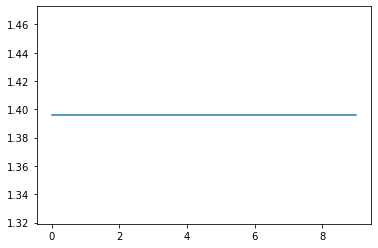

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [287]:
text_pipeline("hi im cool")

[24100, 3722, 2347]

In [292]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = LinearNet(text)
        return output.argmax(1).item() + 1

predict("Kaya", text_pipeline)

ValueError: offsets has to be a 1D Tensor but got None